In [1]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


# Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 1)
train_size=0.00108
# train_size=0.00108 / 64

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi2D     = AWLoss2DFFT(reduction="sum", std=1e-4, store_filters="norm", epsilon=3e-7)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse  

No GPU available! Running on CPU


In [3]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            if epoch < switch_at_epoch:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            else:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi2D, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi2D(recon, X)
                v, T = awi2D.filters[0][0], awi2D.T

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())

                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].imshow(T.detach().cpu().numpy())
                axs[1, 0].set_title("T-2D")

                axs[1, 1].imshow(v.detach().cpu().numpy())
                axs[1, 1].set_title("v-2D")

                axs[1, 2].plot((T.flatten() - v.flatten()).detach().cpu().numpy())
                axs[1, 2].set_ylim(None, 1.1)
                axs[1, 2].set_title("T2D - v2D")

                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss2d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# MNIST Example

## Datasets and Dataloaders

In [4]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("./", download=True, train=True, transform=train_transform)
try:
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
    train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
except:
    train_idx=[7]
X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 64
torch.Size([1, 1, 28, 28]) 0.0 0.9960784316062927


## Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /tmp/pip-req-build-9n7gsq15/aten/src/ATen/native/Copy.cpp:219.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.23149365186691284, 'train_awi1d_loss': 3.996450662612915, 'train_kl_loss': 0.0}
 argidx T, v:  1512 752


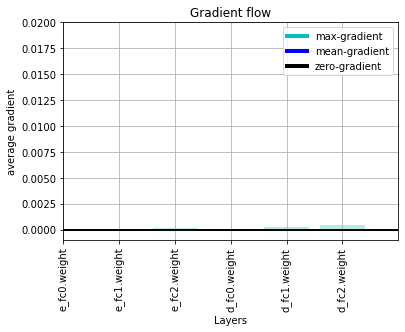

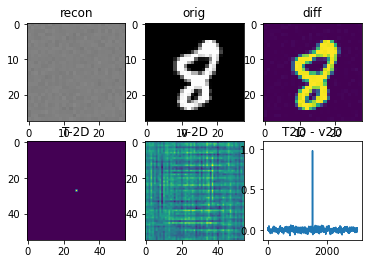

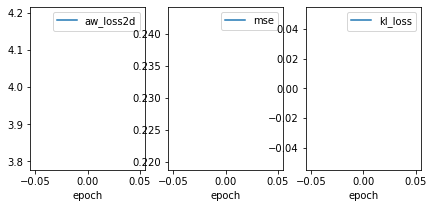

  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:03:10
  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:02:16
  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:54
  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:15
  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:08
  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:07
  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:09
  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:13
  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:23
 10% (10 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:36
 11% (11 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:35
 12% (12 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:26
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.2352094054222107, 'train_awi1d_loss': 3.6198840141296387, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


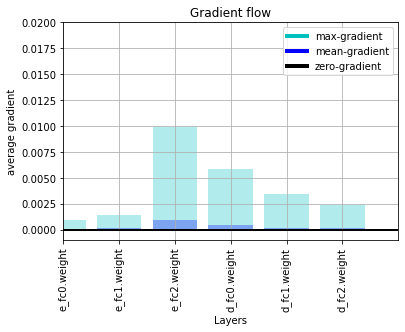

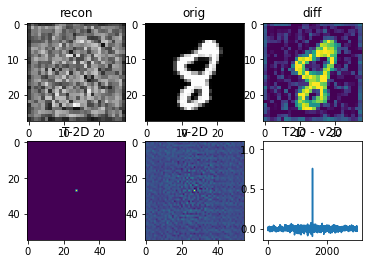

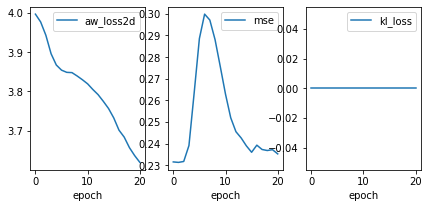

 21% (21 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:01:48
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:20 ETA:   0:01:34
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:15
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:10
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:22 ETA:   0:00:48
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:00:50
 27% (27 of 100) |######                 | Elapsed Time: 0:00:23 ETA:   0:00:48
 28% (28 of 100) |######                 | Elapsed Time: 0:00:24 ETA:   0:00:49
 29% (29 of 100) |######                 | Elapsed Time: 0:00:25 ETA:   0:00:56
 30% (30 of 100) |######                 | Elapsed Time: 0:00:26 ETA:   0:01:01
 31% (31 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:58
 32% (32 of 100) |#######                | Elapsed Time: 0:00:27 ETA:   0:00:56
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.20698629319667816, 'train_awi1d_loss': 3.1967835426330566, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


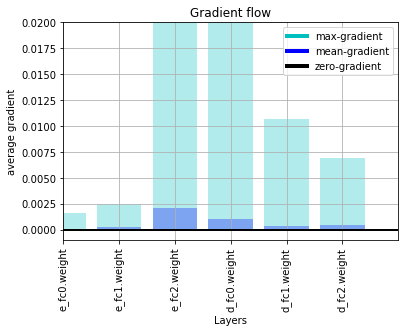

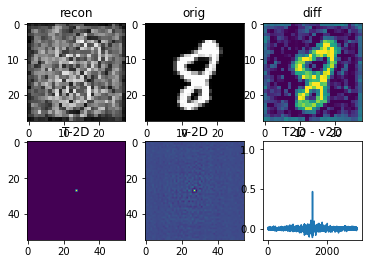

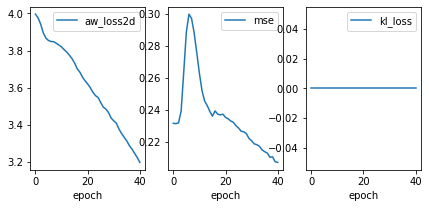

 41% (41 of 100) |#########              | Elapsed Time: 0:00:36 ETA:   0:01:26
 42% (42 of 100) |#########              | Elapsed Time: 0:00:37 ETA:   0:01:20
 43% (43 of 100) |#########              | Elapsed Time: 0:00:38 ETA:   0:01:08
 44% (44 of 100) |##########             | Elapsed Time: 0:00:39 ETA:   0:00:44
 45% (45 of 100) |##########             | Elapsed Time: 0:00:39 ETA:   0:00:38
 46% (46 of 100) |##########             | Elapsed Time: 0:00:40 ETA:   0:00:36
 47% (47 of 100) |##########             | Elapsed Time: 0:00:41 ETA:   0:00:37
 48% (48 of 100) |###########            | Elapsed Time: 0:00:41 ETA:   0:00:41
 49% (49 of 100) |###########            | Elapsed Time: 0:00:42 ETA:   0:00:37
 50% (50 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:35
 51% (51 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:33
 52% (52 of 100) |###########            | Elapsed Time: 0:00:44 ETA:   0:00:35
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.18120644986629486, 'train_awi1d_loss': 2.7716269493103027, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


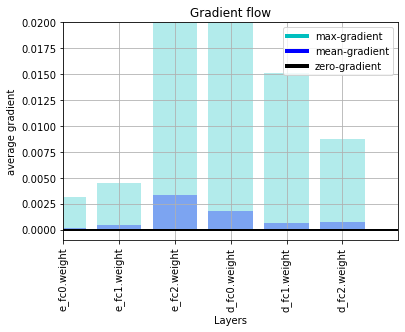

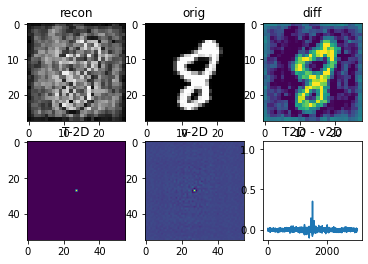

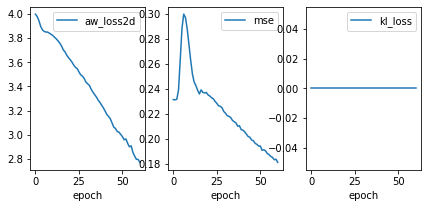

 61% (61 of 100) |##############         | Elapsed Time: 0:00:53 ETA:   0:01:20
 62% (62 of 100) |##############         | Elapsed Time: 0:00:54 ETA:   0:00:55
 63% (63 of 100) |##############         | Elapsed Time: 0:00:55 ETA:   0:00:45
 64% (64 of 100) |##############         | Elapsed Time: 0:00:56 ETA:   0:00:30
 65% (65 of 100) |##############         | Elapsed Time: 0:00:56 ETA:   0:00:27
 66% (66 of 100) |###############        | Elapsed Time: 0:00:57 ETA:   0:00:27
 67% (67 of 100) |###############        | Elapsed Time: 0:00:58 ETA:   0:00:25
 68% (68 of 100) |###############        | Elapsed Time: 0:00:59 ETA:   0:00:25
 69% (69 of 100) |###############        | Elapsed Time: 0:00:59 ETA:   0:00:24
 70% (70 of 100) |################       | Elapsed Time: 0:01:00 ETA:   0:00:25
 71% (71 of 100) |################       | Elapsed Time: 0:01:01 ETA:   0:00:23
 72% (72 of 100) |################       | Elapsed Time: 0:01:02 ETA:   0:00:21
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.16142314672470093, 'train_awi1d_loss': 2.485908031463623, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


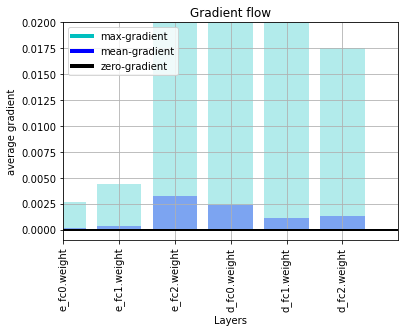

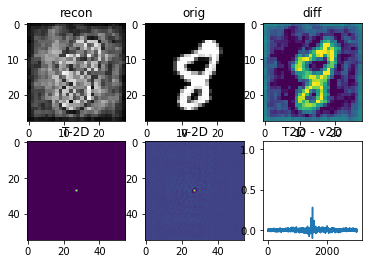

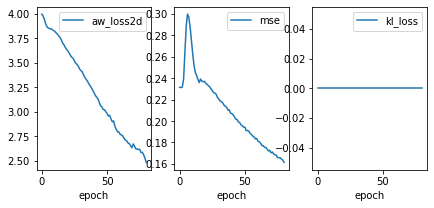

 81% (81 of 100) |##################     | Elapsed Time: 0:01:09 ETA:   0:00:27
 82% (82 of 100) |##################     | Elapsed Time: 0:01:10 ETA:   0:00:26
 83% (83 of 100) |###################    | Elapsed Time: 0:01:11 ETA:   0:00:22
 84% (84 of 100) |###################    | Elapsed Time: 0:01:13 ETA:   0:00:17
 85% (85 of 100) |###################    | Elapsed Time: 0:01:13 ETA:   0:00:14
 86% (86 of 100) |###################    | Elapsed Time: 0:01:14 ETA:   0:00:13
 87% (87 of 100) |####################   | Elapsed Time: 0:01:15 ETA:   0:00:11
 88% (88 of 100) |####################   | Elapsed Time: 0:01:16 ETA:   0:00:11
 89% (89 of 100) |####################   | Elapsed Time: 0:01:17 ETA:   0:00:10
 90% (90 of 100) |####################   | Elapsed Time: 0:01:18 ETA:   0:00:08
 91% (91 of 100) |####################   | Elapsed Time: 0:01:19 ETA:   0:00:07
 92% (92 of 100) |#####################  | Elapsed Time: 0:01:20 ETA:   0:00:06
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.14497873187065125, 'train_awi1d_loss': 2.3110671043395996, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


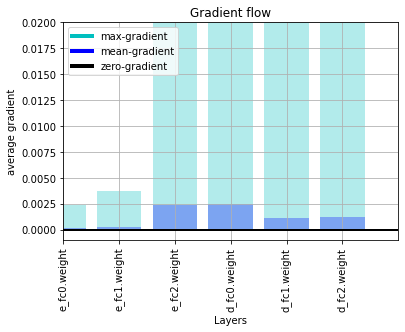

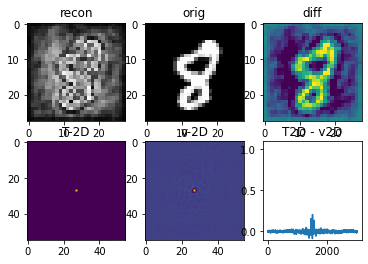

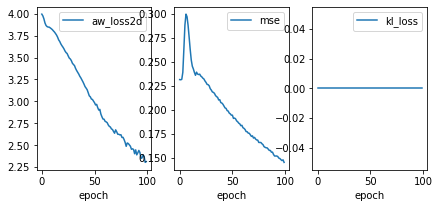

100% (100 of 100) |######################| Elapsed Time: 0:01:26 Time:  0:01:26


In [5]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Visualise Loss Landscape of Autoencoder

Train Subset len:  16
Angle between x_dir and y_dir: 90.01 °


N/A% (0 of 625) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:51
  0% (2 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:49
  0% (3 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:51
  0% (4 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:47
  0% (5 of 625) |                        | Elapsed Time: 0:00:00 ETA:   0:01:44
  0% (6 of 625) |                        | Elapsed Time: 0:00:01 ETA:   0:01:44
  1% (7 of 625) |                        | Elapsed Time: 0:00:01 ETA:   0:01:43
  1% (8 of 625) |                        | Elapsed Time: 0:00:01 ETA:   0:01:42
  1% (9 of 625) |                        | Elapsed Time: 0:00:01 ETA:   0:01:39
  1% (10 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:38
  1% (11 of 625) |                       | Elapsed Time: 0:00:01 ETA:   0:01:38
  1% (12 of 625) |                      

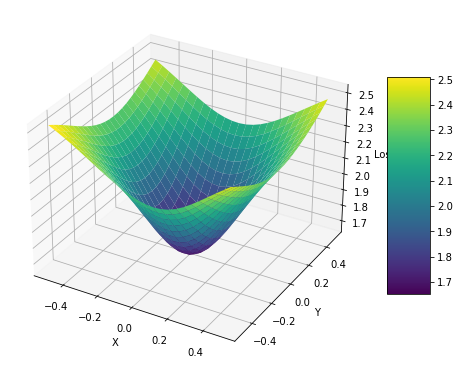

In [6]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi2D, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.23165680468082428, 'train_awi1d_loss': 3.995846748352051, 'train_kl_loss': 517.2866821289062}
 argidx T, v:  1512 1522


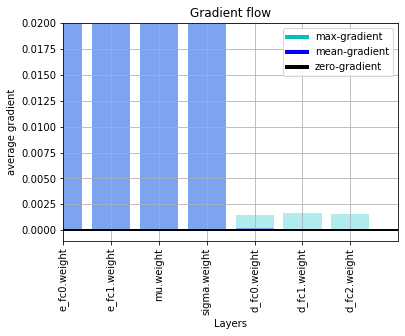

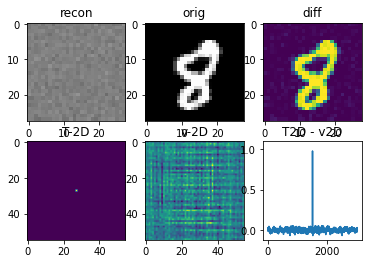

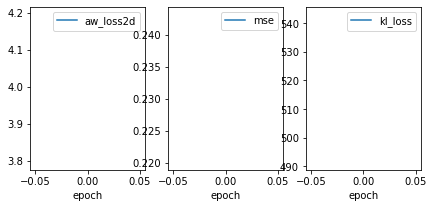

  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:45
  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:54
  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:37
  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:26
  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:03
  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:03
  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:04
  8% (8 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:01
  9% (9 of 100) |##                      | Elapsed Time: 0:00:07 ETA:   0:01:00
 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:00
 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:02
 12% (12 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:01
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.2481946051120758, 'train_awi1d_loss': 3.842349052429199, 'train_kl_loss': 512.0299072265625}
 argidx T, v:  1512 1512


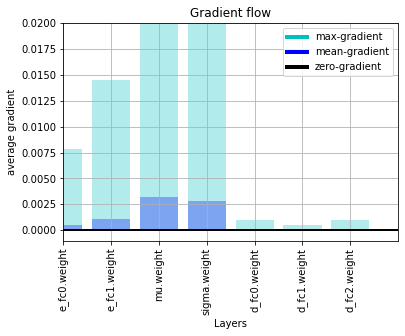

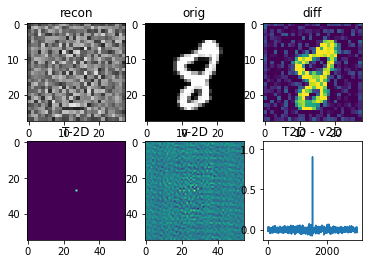

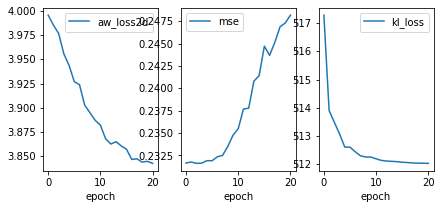

 21% (21 of 100) |####                   | Elapsed Time: 0:00:15 ETA:   0:01:27
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:16 ETA:   0:01:29
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:16
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:17 ETA:   0:01:07
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:44
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:18 ETA:   0:00:38
 27% (27 of 100) |######                 | Elapsed Time: 0:00:19 ETA:   0:00:39
 28% (28 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:41
 29% (29 of 100) |######                 | Elapsed Time: 0:00:20 ETA:   0:00:51
 30% (30 of 100) |######                 | Elapsed Time: 0:00:21 ETA:   0:00:50
 31% (31 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:48
 32% (32 of 100) |#######                | Elapsed Time: 0:00:22 ETA:   0:00:49
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.24470874667167664, 'train_awi1d_loss': 3.8346548080444336, 'train_kl_loss': 512.0023193359375}
 argidx T, v:  1512 1512


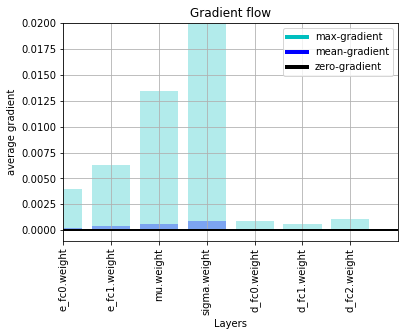

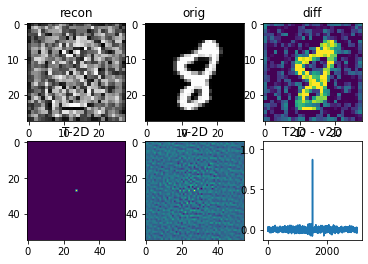

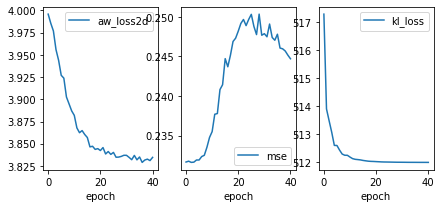

 41% (41 of 100) |#########              | Elapsed Time: 0:00:29 ETA:   0:01:07
 42% (42 of 100) |#########              | Elapsed Time: 0:00:30 ETA:   0:01:10
 43% (43 of 100) |#########              | Elapsed Time: 0:00:31 ETA:   0:00:58
 44% (44 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:40
 45% (45 of 100) |##########             | Elapsed Time: 0:00:32 ETA:   0:00:37
 46% (46 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:36
 47% (47 of 100) |##########             | Elapsed Time: 0:00:33 ETA:   0:00:35
 48% (48 of 100) |###########            | Elapsed Time: 0:00:34 ETA:   0:00:33
 49% (49 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:34
 50% (50 of 100) |###########            | Elapsed Time: 0:00:35 ETA:   0:00:33
 51% (51 of 100) |###########            | Elapsed Time: 0:00:36 ETA:   0:00:34
 52% (52 of 100) |###########            | Elapsed Time: 0:00:37 ETA:   0:00:32
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.23271062970161438, 'train_awi1d_loss': 3.823894500732422, 'train_kl_loss': 512.000732421875}
 argidx T, v:  1512 1512


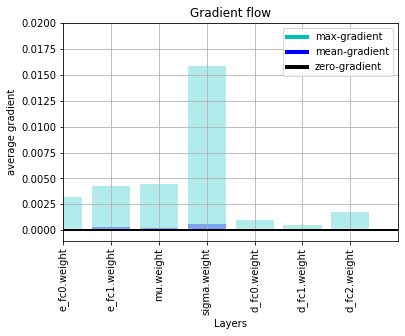

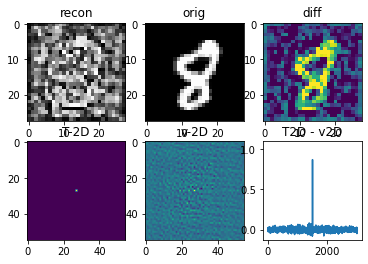

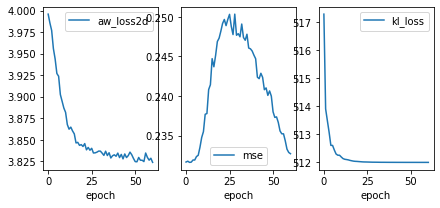

 61% (61 of 100) |##############         | Elapsed Time: 0:00:44 ETA:   0:00:48
 62% (62 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:45
 63% (63 of 100) |##############         | Elapsed Time: 0:00:45 ETA:   0:00:37
 64% (64 of 100) |##############         | Elapsed Time: 0:00:46 ETA:   0:00:33
 65% (65 of 100) |##############         | Elapsed Time: 0:00:47 ETA:   0:00:22
 66% (66 of 100) |###############        | Elapsed Time: 0:00:47 ETA:   0:00:22
 67% (67 of 100) |###############        | Elapsed Time: 0:00:48 ETA:   0:00:22
 68% (68 of 100) |###############        | Elapsed Time: 0:00:49 ETA:   0:00:24
 69% (69 of 100) |###############        | Elapsed Time: 0:00:50 ETA:   0:00:24
 70% (70 of 100) |################       | Elapsed Time: 0:00:50 ETA:   0:00:22
 71% (71 of 100) |################       | Elapsed Time: 0:00:51 ETA:   0:00:20
 72% (72 of 100) |################       | Elapsed Time: 0:00:52 ETA:   0:00:19
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.2202545404434204, 'train_awi1d_loss': 3.825860023498535, 'train_kl_loss': 512.0015869140625}
 argidx T, v:  1512 1512


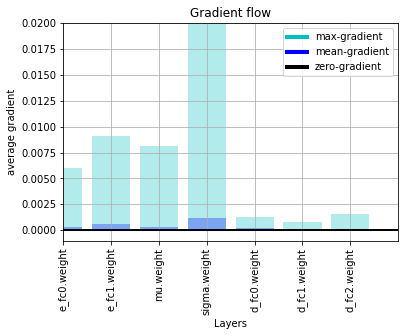

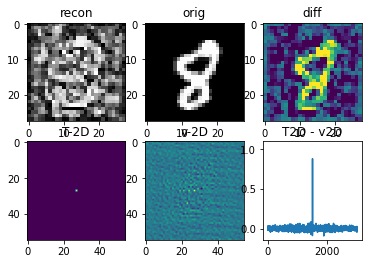

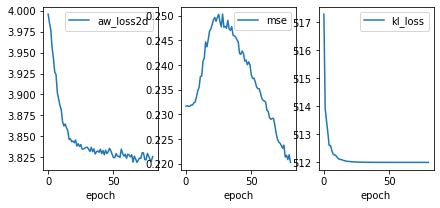

 81% (81 of 100) |##################     | Elapsed Time: 0:00:58 ETA:   0:00:20
 82% (82 of 100) |##################     | Elapsed Time: 0:00:59 ETA:   0:00:20
 83% (83 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:16
 84% (84 of 100) |###################    | Elapsed Time: 0:01:00 ETA:   0:00:10
 85% (85 of 100) |###################    | Elapsed Time: 0:01:01 ETA:   0:00:09
 86% (86 of 100) |###################    | Elapsed Time: 0:01:02 ETA:   0:00:09
 87% (87 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08
 88% (88 of 100) |####################   | Elapsed Time: 0:01:03 ETA:   0:00:08
 89% (89 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:07
 90% (90 of 100) |####################   | Elapsed Time: 0:01:04 ETA:   0:00:06
 91% (91 of 100) |####################   | Elapsed Time: 0:01:05 ETA:   0:00:06
 92% (92 of 100) |#####################  | Elapsed Time: 0:01:06 ETA:   0:00:05
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.2083350569009781, 'train_awi1d_loss': 3.824228525161743, 'train_kl_loss': 512.0152587890625}
 argidx T, v:  1512 1512


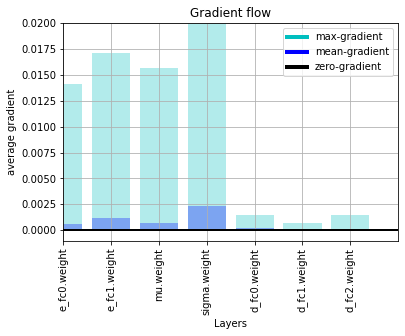

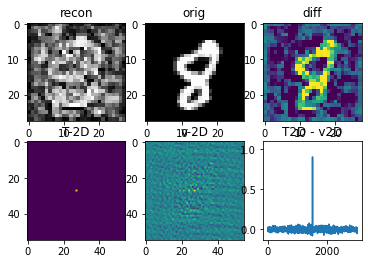

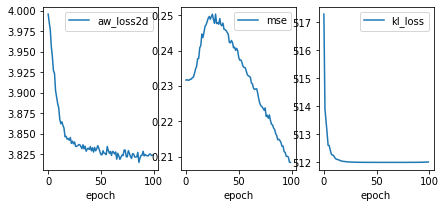

100% (100 of 100) |######################| Elapsed Time: 0:01:12 Time:  0:01:12


In [7]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.21212434768676758, 'train_awi1d_loss': 3.994746685028076, 'train_kl_loss': 0.0}
 argidx T, v:  1512 752


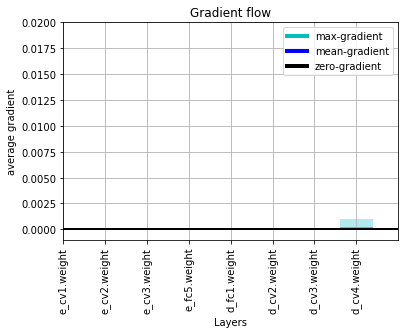

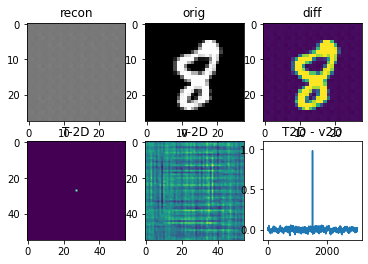

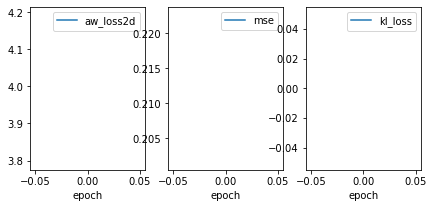

  1% (1 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:07:44
  2% (2 of 100) |                        | Elapsed Time: 0:00:08 ETA:   0:06:03
  3% (3 of 100) |                        | Elapsed Time: 0:00:12 ETA:   0:06:05
  4% (4 of 100) |                        | Elapsed Time: 0:00:15 ETA:   0:05:43
  5% (5 of 100) |#                       | Elapsed Time: 0:00:18 ETA:   0:04:29
  6% (6 of 100) |#                       | Elapsed Time: 0:00:21 ETA:   0:05:12
  7% (7 of 100) |#                       | Elapsed Time: 0:00:25 ETA:   0:05:43
  8% (8 of 100) |#                       | Elapsed Time: 0:00:29 ETA:   0:06:22
  9% (9 of 100) |##                      | Elapsed Time: 0:00:32 ETA:   0:04:48
 10% (10 of 100) |##                     | Elapsed Time: 0:00:36 ETA:   0:05:47
 11% (11 of 100) |##                     | Elapsed Time: 0:00:40 ETA:   0:05:11
 12% (12 of 100) |##                     | Elapsed Time: 0:00:42 ETA:   0:03:21
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.250325083732605, 'train_awi1d_loss': 3.839500904083252, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


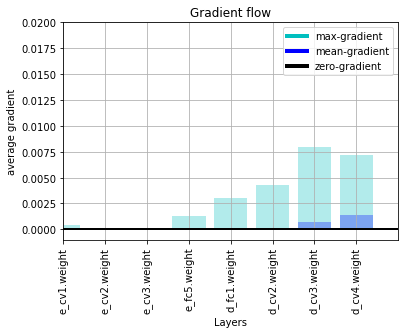

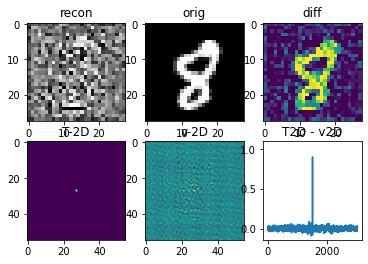

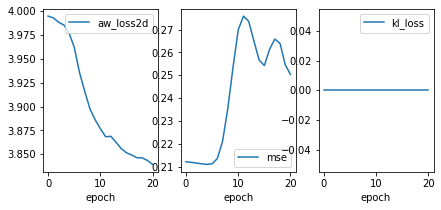

 21% (21 of 100) |####                   | Elapsed Time: 0:01:15 ETA:   0:07:09
 22% (22 of 100) |#####                  | Elapsed Time: 0:01:19 ETA:   0:04:52
 23% (23 of 100) |#####                  | Elapsed Time: 0:01:23 ETA:   0:05:30
 24% (24 of 100) |#####                  | Elapsed Time: 0:01:27 ETA:   0:04:37
 25% (25 of 100) |#####                  | Elapsed Time: 0:01:31 ETA:   0:05:38
 26% (26 of 100) |#####                  | Elapsed Time: 0:01:35 ETA:   0:04:48
 27% (27 of 100) |######                 | Elapsed Time: 0:01:38 ETA:   0:03:31
 28% (28 of 100) |######                 | Elapsed Time: 0:01:42 ETA:   0:05:07
 29% (29 of 100) |######                 | Elapsed Time: 0:01:47 ETA:   0:05:44
 30% (30 of 100) |######                 | Elapsed Time: 0:01:51 ETA:   0:04:49
 31% (31 of 100) |#######                | Elapsed Time: 0:01:54 ETA:   0:03:49
 32% (32 of 100) |#######                | Elapsed Time: 0:01:59 ETA:   0:05:09
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.2533964514732361, 'train_awi1d_loss': 3.7296319007873535, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


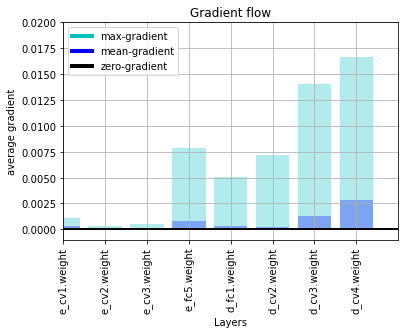

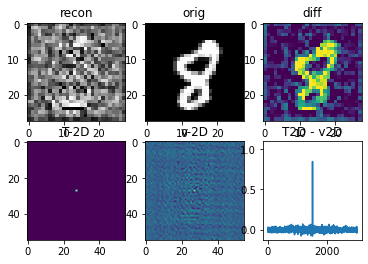

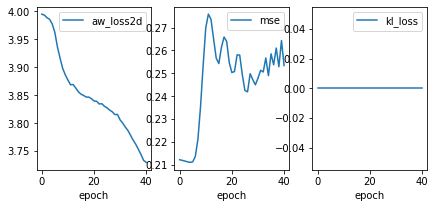

 41% (41 of 100) |#########              | Elapsed Time: 0:02:31 ETA:   0:04:55
 42% (42 of 100) |#########              | Elapsed Time: 0:02:34 ETA:   0:03:39
 43% (43 of 100) |#########              | Elapsed Time: 0:02:38 ETA:   0:03:07
 44% (44 of 100) |##########             | Elapsed Time: 0:02:41 ETA:   0:03:25
 45% (45 of 100) |##########             | Elapsed Time: 0:02:45 ETA:   0:03:04
 46% (46 of 100) |##########             | Elapsed Time: 0:02:49 ETA:   0:03:34
 47% (47 of 100) |##########             | Elapsed Time: 0:02:53 ETA:   0:04:03
 48% (48 of 100) |###########            | Elapsed Time: 0:02:58 ETA:   0:03:38
 49% (49 of 100) |###########            | Elapsed Time: 0:03:01 ETA:   0:02:55
 50% (50 of 100) |###########            | Elapsed Time: 0:03:05 ETA:   0:03:07
 51% (51 of 100) |###########            | Elapsed Time: 0:03:09 ETA:   0:03:12
 52% (52 of 100) |###########            | Elapsed Time: 0:03:12 ETA:   0:03:03
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.2436300814151764, 'train_awi1d_loss': 3.510709285736084, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


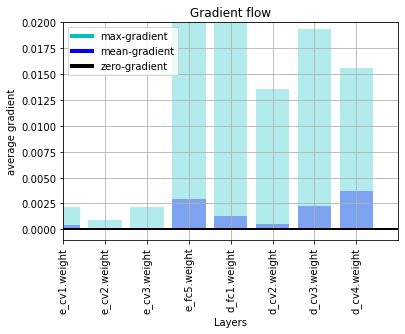

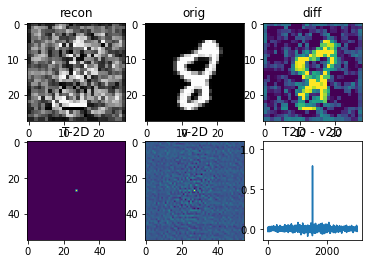

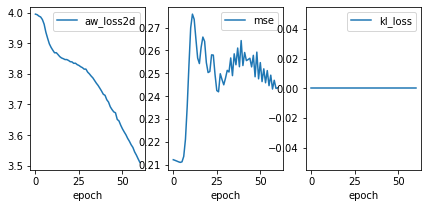

 61% (61 of 100) |##############         | Elapsed Time: 0:03:48 ETA:   0:02:58
 62% (62 of 100) |##############         | Elapsed Time: 0:03:52 ETA:   0:02:17
 63% (63 of 100) |##############         | Elapsed Time: 0:03:56 ETA:   0:02:27
 64% (64 of 100) |##############         | Elapsed Time: 0:03:56 ETA:   0:01:22
 65% (65 of 100) |##############         | Elapsed Time: 0:04:00 ETA:   0:02:05
 66% (66 of 100) |###############        | Elapsed Time: 0:04:04 ETA:   0:02:19
 67% (67 of 100) |###############        | Elapsed Time: 0:04:08 ETA:   0:02:19
 68% (68 of 100) |###############        | Elapsed Time: 0:04:12 ETA:   0:01:48
 69% (69 of 100) |###############        | Elapsed Time: 0:04:15 ETA:   0:01:51
 70% (70 of 100) |################       | Elapsed Time: 0:04:19 ETA:   0:01:40
 71% (71 of 100) |################       | Elapsed Time: 0:04:21 ETA:   0:01:19
 72% (72 of 100) |################       | Elapsed Time: 0:04:25 ETA:   0:01:32
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.2293665111064911, 'train_awi1d_loss': 3.332955837249756, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


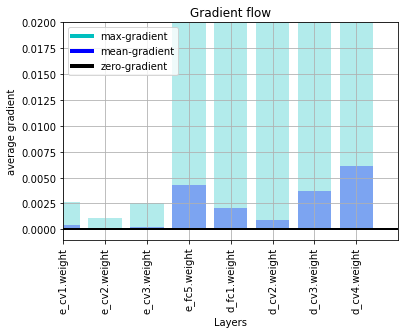

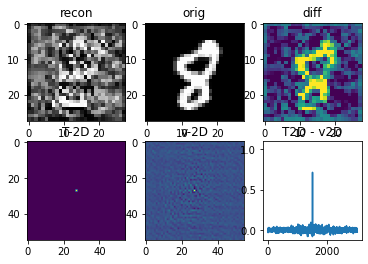

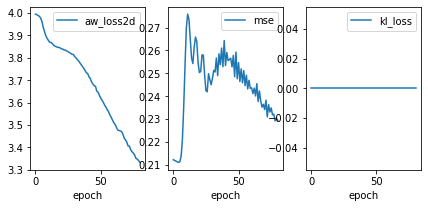

 81% (81 of 100) |##################     | Elapsed Time: 0:04:59 ETA:   0:01:21
 82% (82 of 100) |##################     | Elapsed Time: 0:05:03 ETA:   0:01:16
 83% (83 of 100) |###################    | Elapsed Time: 0:05:07 ETA:   0:01:00
 84% (84 of 100) |###################    | Elapsed Time: 0:05:11 ETA:   0:00:59
 85% (85 of 100) |###################    | Elapsed Time: 0:05:14 ETA:   0:00:55
 86% (86 of 100) |###################    | Elapsed Time: 0:05:18 ETA:   0:00:44
 87% (87 of 100) |####################   | Elapsed Time: 0:05:22 ETA:   0:00:55
 88% (88 of 100) |####################   | Elapsed Time: 0:05:26 ETA:   0:00:49
 89% (89 of 100) |####################   | Elapsed Time: 0:05:30 ETA:   0:00:39
 90% (90 of 100) |####################   | Elapsed Time: 0:05:33 ETA:   0:00:36
 91% (91 of 100) |####################   | Elapsed Time: 0:05:37 ETA:   0:00:34
 92% (92 of 100) |#####################  | Elapsed Time: 0:05:38 ETA:   0:00:18
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.21687361598014832, 'train_awi1d_loss': 3.2000784873962402, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


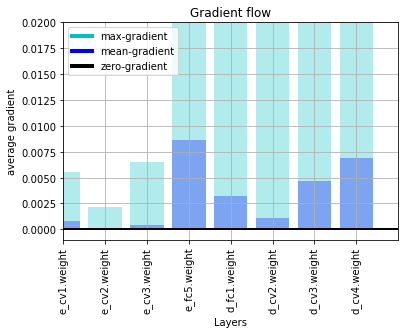

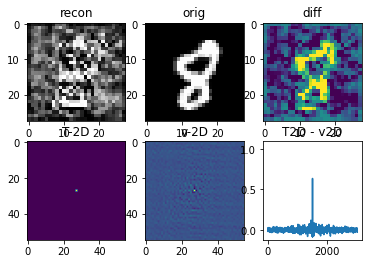

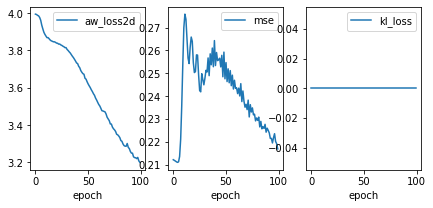

100% (100 of 100) |######################| Elapsed Time: 0:06:01 Time:  0:06:01


In [8]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.24413540959358215, 'train_awi1d_loss': 3.9953269958496094, 'train_kl_loss': 518.8905029296875}
 argidx T, v:  1512 752


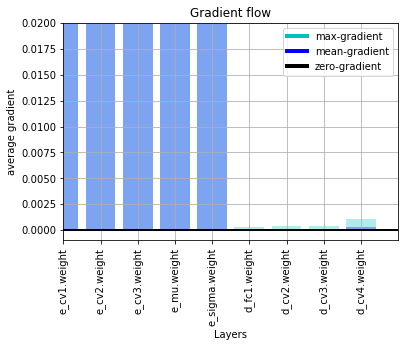

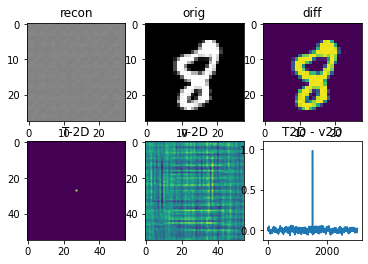

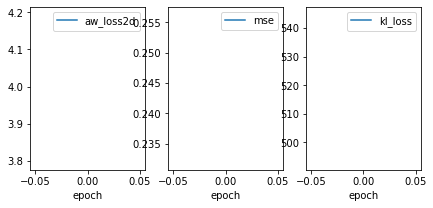

  1% (1 of 100) |                        | Elapsed Time: 0:00:06 ETA:   0:10:36
  2% (2 of 100) |                        | Elapsed Time: 0:00:09 ETA:   0:05:29
  3% (3 of 100) |                        | Elapsed Time: 0:00:13 ETA:   0:06:41
  4% (4 of 100) |                        | Elapsed Time: 0:00:17 ETA:   0:05:37
  5% (5 of 100) |#                       | Elapsed Time: 0:00:21 ETA:   0:06:01
  6% (6 of 100) |#                       | Elapsed Time: 0:00:25 ETA:   0:06:06
  7% (7 of 100) |#                       | Elapsed Time: 0:00:28 ETA:   0:05:32
  8% (8 of 100) |#                       | Elapsed Time: 0:00:32 ETA:   0:05:15
  9% (9 of 100) |##                      | Elapsed Time: 0:00:35 ETA:   0:05:00
 10% (10 of 100) |##                     | Elapsed Time: 0:00:38 ETA:   0:04:00
 11% (11 of 100) |##                     | Elapsed Time: 0:00:42 ETA:   0:06:16
 12% (12 of 100) |##                     | Elapsed Time: 0:00:45 ETA:   0:04:48
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.23424455523490906, 'train_awi1d_loss': 3.939121723175049, 'train_kl_loss': 512.0458984375}
 argidx T, v:  1512 2064


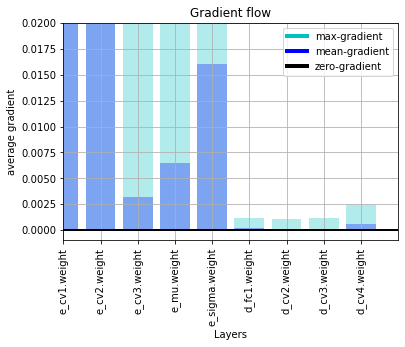

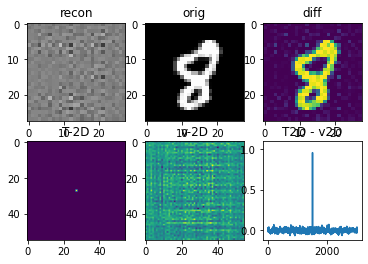

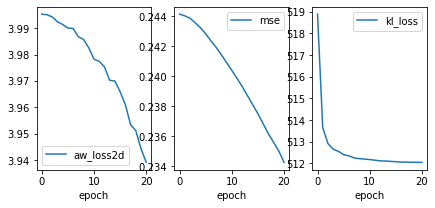

 21% (21 of 100) |####                   | Elapsed Time: 0:01:22 ETA:   0:06:26
 22% (22 of 100) |#####                  | Elapsed Time: 0:01:25 ETA:   0:04:49
 23% (23 of 100) |#####                  | Elapsed Time: 0:01:27 ETA:   0:03:09


KeyboardInterrupt: 

In [9]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)